## Prophet Diagnostics

Forecasts are done over a predetermined “horizon” (e.g., 30 days) where each future state (e.g., day) is associated with some error. The philosophy behind evaluation is to compare the Prophet forecast with simple baseline models (e.g., average, or last value), as well as automated models (e.g., ARIMA, etc.).

*See [documentation](https://facebook.github.io/prophet/docs/diagnostics.html) for more.*

In [1]:
import plotly.express as px
import pandas as pd

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_from_json

In [2]:
with open('./model.json', 'r') as f:
    model = model_from_json(f.read())  # Load model

In [3]:
df_cv = cross_validation(model, 
                         initial='1825 days',  # the first evaluation will use five years
                         period='180 days',  # simulate forecast at every <this> period
                         horizon='365 days')  # how "wide" each forecast will be

  0%|          | 0/5 [00:00<?, ?it/s]

10:47:05 - cmdstanpy - INFO - Chain [1] start processing
10:47:06 - cmdstanpy - INFO - Chain [1] done processing
10:47:06 - cmdstanpy - INFO - Chain [1] start processing
10:47:06 - cmdstanpy - INFO - Chain [1] done processing
10:47:06 - cmdstanpy - INFO - Chain [1] start processing
10:47:06 - cmdstanpy - INFO - Chain [1] done processing
10:47:07 - cmdstanpy - INFO - Chain [1] start processing
10:47:07 - cmdstanpy - INFO - Chain [1] done processing
10:47:07 - cmdstanpy - INFO - Chain [1] start processing
10:47:07 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
df_cv.sort_values('ds', inplace=True)

In [5]:
df_cv.head()

ds      yhat  yhat_lower  yhat_upper          y     cutoff
0 2013-01-31  9.324858    8.715600    9.952530   8.485496 2013-01-30
1 2013-02-01  9.318848    8.687947    9.932178   8.577912 2013-01-30
2 2013-02-02  9.104111    8.473258    9.710447   8.549854 2013-01-30
3 2013-02-03  9.445507    8.815789   10.052473   9.606226 2013-01-30
4 2013-02-04  9.652634    9.043515   10.311847  10.026192 2013-01-30

Instead of looking at the parametric error expected from a model (e.g., the amount of “noise”, normally distributed, for an AR model, say), the evaluation is done (roughly) by evaluating a few different historical forecasts on historical real data to generate an expected error for the future. This method is called Simulated Historical Forecasting (SHF). As described in the Prophet paper,

**"SHFs simulate the errors we would have made had we used this forecasting method at those points in the past."**

1. Use data from $t = 0$ to $t = \texttt{initial}$ to forecast the first`horizon`
2. Use data from $t = 0$ to $t = \texttt{initial} + \texttt{period}$ to forecast the next `horizon`
3. Use data from $t = 0$ to $t = \texttt{initial} + 2\texttt{period}$ to forecast the next `horizon`
4. $\dots$

The heuristic used is to make a forecast every `period` periods.

* With `period` too small, the difference between forecasts is too correlated, and doesn’t capture variability much. 
* With `period` too big, there’s not enough variability, and not enough support for our evaluation comparison
* More data is not necessarily better. Maybe more recent data is better, maybe just better data is better. Try different sets to be sure.

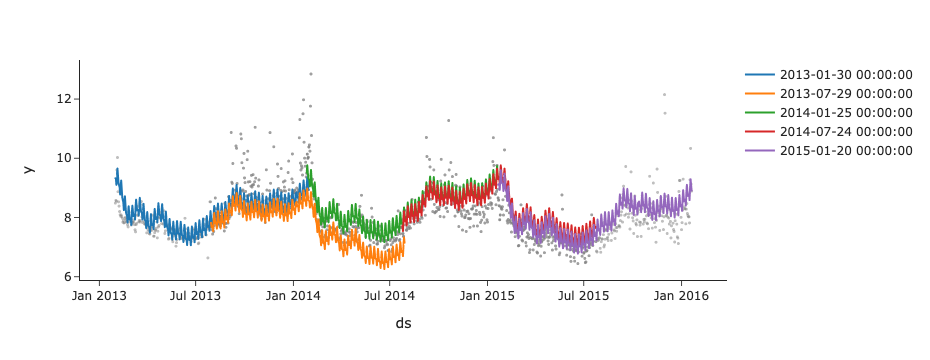

In [6]:
y_true = px.scatter(df_cv, x='ds', y='y', template='simple_white', 
                    opacity=0.5, color_discrete_sequence=['gray'])

y_pred = px.line(df_cv, x='ds', y='yhat', color='cutoff', 
                 template='simple_white')

y_true.add_traces(y_pred.data)
y_true.update_traces(marker={'size': 3})

In [7]:
df_p = performance_metrics(df_cv)

In [8]:
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.331512  0.575771  0.408237  0.048245  0.039246  0.047548   
1 38 days  0.329428  0.573959  0.407975  0.048294  0.043449  0.047614   
2 39 days  0.367091  0.605881  0.421030  0.049602  0.043449  0.049093   
3 40 days  0.372654  0.610454  0.425580  0.050231  0.043449  0.049745   
4 41 days  0.367609  0.606307  0.422871  0.050031  0.043853  0.049554   

   coverage  
0  0.786740  
1  0.792265  
2  0.786740  
3  0.783425  
4  0.788950

So, for `mse`, at row `1`, we ask *"what is the mean squared error between `yhat` and `y` (in `df_cv`) among all the different horizon-cutoffs?*

In [9]:
df_p['horizon_adj'] = df_cv.ds.min() + pd.Timedelta(-1, 'day') + df_p['horizon']

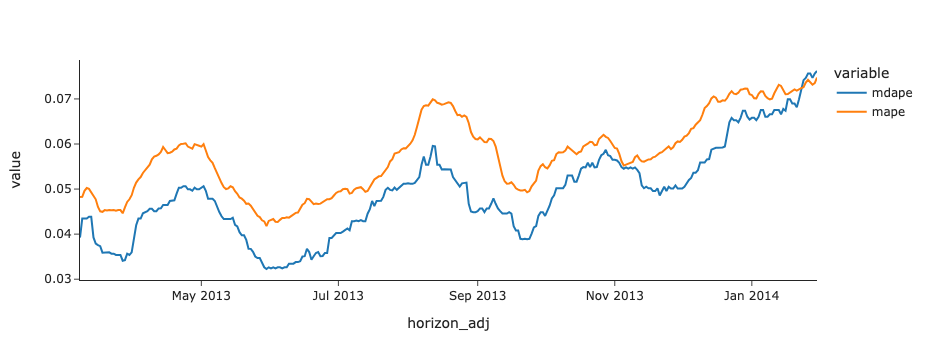

In [10]:
px.line(data_frame=df_p, x='horizon_adj', y=['mdape', 'mape'], template='simple_white')

Interesting our model is getting worse with more data ... Maybe we want to try reducing the sensitivity to change points, or potentially include more information (e.g., holidays).